In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load data

In [3]:
from helper import load_data, normalize_data

data = load_data()
(N, d) = data.shape
print("Number of data points: ", N)
print("Dimension of each data point: ", d)

Number of data points:  272
Dimension of each data point:  2


### Initialize your cluster centers

In [89]:
def initialize_clusters(data, k_num):
    """randomly initialize the k cluster centers (the means). Make sure you choose k clusters from the data itself,
             or ensure otherwise that your initializations have the same scale as the data
    
    Args:
        data: shape = (N, d). original data. 
        k: integer number. predefined number of clusters for the k-means algorithm. 
    Returns:
        numpy array with shape (k, d) which corresponds to the k initial clusters.
    """
    index = np.arange(data.shape[0])
    ch = np.random.choice(index, k_num, replace=False)
    return data[ch]

In [136]:
def k_meanspp(data, k_num):
    """randomly initialize the k cluster centers (the means). Make sure you choose k clusters from the data itself,
             or ensure otherwise that your initializations have the same scale as the data
    
    Args:
        data: shape = (N, d). original data. 
        k: integer number. predefined number of clusters for the k-means algorithm. 
    Returns:
        numpy array with shape (k, d) which corresponds to the k initial clusters.
    """
    mu = np.zeros((k_num, data.shape[1]))
    X = np.arange(data.shape[0])
    ch = np.random.choice(X)
    mu[0] = data[ch]
    X = np.delete(X, ch)
    D = np.linalg.norm(data[X] - mu[0], axis=1)
    for k in range(1, k_num):
        ch = np.random.choice(X, p= (D**2 / np.sum(D**2)))
        mu[k] = data[ch]
        X = np.delete(X, ch)
        D = np.linalg.norm(data[X] - mu[k], axis=1)
        
    return mu

### Update k-means parameters

#### Build distance matrix
Build a distance matrix, collecting the distances of the original dataset to the means of the clusters.

NOTE: once you finish your `build_distance_matrix`, please copy the function to the `helper.py` function. Otherwise, the `kmeans` function will not work.

In [6]:
def build_distance_matrix(data, mu):
    """builds a distance matrix.
    
    Args:
        data: numpy array of shape = (N, d). original data. 
        mu:   numpy array of shape = (k, d). Each row corresponds to a cluster center.
    Returns:
        numpy array of shape (N, k):
            squared distances matrix,  
            the value row i column j corresponds to the squared distance of datapoint i with cluster center j.
    """
    return np.linalg.norm(data[:, np.newaxis, :] - mu[np.newaxis, :, :], axis=2) ** 2

#### Update k-means parameters

In [38]:
def update_kmeans_parameters(data, mu_old):
    """compute one step of the kmeans algorithm: using mu_old, find to which cluster each datapoint belongs to, 
            then update the parameter cluster centers.
    
    Args:
        data:   numpy array of shape = (N, d). original data. 
        mu_old: numpy array of shape = (k, d). Each row corresponds to a cluster center.
    Returns:
        losses: shape (N, ), contains the (old) squared distances of each data point to its (old) cluster mean (computed from mu_old).
        assignments: vector of shape (N, ) which contains the cluster associated to each data point.
        mu: updated vector mu of shape (k, d) where each row corresponds to the new cluster center.
    """
    losses = build_distance_matrix(data, mu_old)
    assignments = np.argmin(losses, axis=1)
    loss = losses[np.arange(losses.shape[0]), assignments]
    mu = [np.mean(data[np.where(assignments==k)], axis=0) 
          for k in range(mu_old.shape[0])]
    mu = np.array(mu)
    return loss, assignments, mu

#### Play with k-means

The current iteration of k-means is: 0, the average loss is 33.00639623161765.


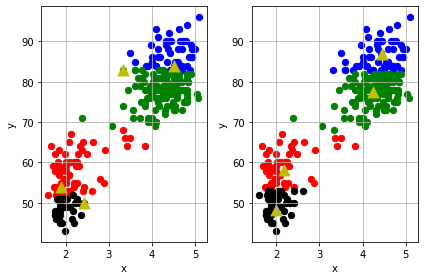

The current iteration of k-means is: 1, the average loss is 12.580548726831239.


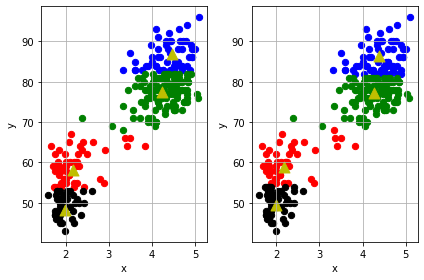

The current iteration of k-means is: 2, the average loss is 11.77284372606961.


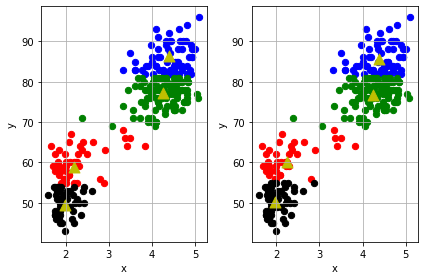

The current iteration of k-means is: 3, the average loss is 11.140827451783789.


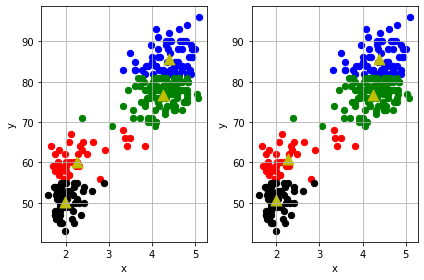

The current iteration of k-means is: 4, the average loss is 11.005860314471086.


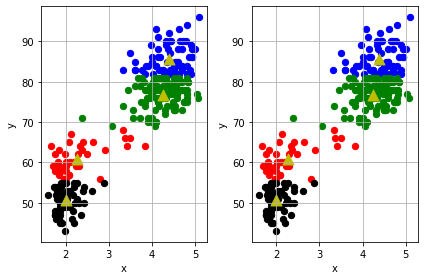

The current iteration of k-means is: 5, the average loss is 11.005860314471086.


In [142]:
from helper import build_dir
from plots import plot

def kmeans(data, k, max_iters, threshold, verbose = True):
    """run the k-means algorithm."""
    output_figure = "kmeans_figures/"
    # initialize the cluster.
    mu_old = k_meanspp(data, k)
    # init some empty lists to store the result.
    loss_list = []

    # start the kmeans algorithm.
    for iteration in range(max_iters):
        # update z and mu
        losses, assignments, mu = update_kmeans_parameters(data, mu_old)
        # calculate the average loss over all points
        average_loss = np.mean(losses)
        loss_list.append(average_loss)
        if verbose:
            print(("The current iteration of k-means is: {i}, " +
                  "the average loss is {l}.").format(i=iteration, l=average_loss))
        # check convergence
        if iteration > 0 and np.abs(loss_list[-1] - loss_list[-2]) < threshold:
            break
        # output plot
        if verbose:
            plot(data, mu, mu_old, output_figure + "kmean_iter{i}".format(i=iteration))
        # update k-means information.
        mu_old = mu
    return mu, assignments, average_loss

# define parameters
k = 4
max_iters = 10
threshold = 1e-5
output_figure = "kmeans_figures/"

# build figure dir
build_dir(output_figure)

# run kmeans algorithm
average_loss = kmeans(data, k, max_iters, threshold)

### Plotting the loss as a function of number of clusters

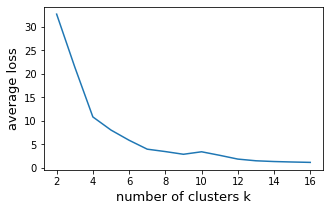

In [77]:
# don't worry about empty slice warnings
import warnings
warnings.filterwarnings("ignore")

losses = []
ks = np.arange(2, 17)
for k in ks:
    _, _, average_loss = kmeans(data, k, max_iters, threshold, verbose = False)
    losses += [average_loss]
plt.figure(figsize = (5, 3))
plt.xlabel('number of clusters k', fontsize = 13)
plt.ylabel('average loss', fontsize = 13)
plt.plot(ks, losses)
plt.show()

## Using k-means for image compresson

#### load image

In [61]:
from helper import load_image

image_path = "mandrill.png"
original_image = load_image(image_path)
print(
    "Original image: the shape of image={s}, the data type={dt}.".format(
        s=original_image.shape, dt=original_image.dtype))

Original image: the shape of image=(480, 480, 3), the data type=float32.


#### preprocess image

In [74]:
def preprocess_image(original_image):
    """preprocess the image. 
    vectorize the three matrices (each matrix corresponds to a RGB color channel). **don't normalize!** 
    
    Args: 
        original_image: numpy array of shape (480, 480, 3) 
    Returns:
        processed_image: numpy array of shape (480*480, 3)
    """
    return original_image.reshape(480*480, 3)

processed_image = preprocess_image(original_image)

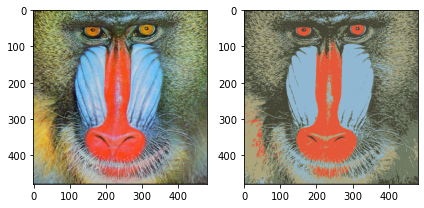

In [88]:
from plots import plot_image_compression

def kmean_compression(original_image, processed_image, k, max_iters, threshold):
    """using k-means for image compression.
    Args: 
        original_image: numpy array of shape (480, 480, 3).
        processed_image: numpy array of shape (480*480, 3).
        k: scalar. Number of clusters.
        max_iters: integer. Max number of iterations for the kmeans algorithm.
        threshold: scalar. Stop the kmeans algorithm if the loss decrease between two iterations
                        is lower than the threshold.
    """
    
    mu, assignments, _ = kmeans(processed_image, k, max_iters, threshold, verbose=False)
    # plot histogram
    plot_image_compression(original_image, processed_image, assignments, mu, k)
    

# define parameters
k = 5
max_iter = 100
threshold = 1e-7

# use kmeans to compress image
kmean_compression(original_image, processed_image, k, max_iter, threshold)